<a href="https://colab.research.google.com/github/Niharshith-2044/XAI-practical/blob/main/DIABETES_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ===== Cell 1: Imports & Settings =====
import warnings
warnings.filterwarnings("ignore")
import os, random, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# DL
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping

# XAI
import shap
try:
    import lime
    from lime.lime_tabular import LimeTabularExplainer
    LIME_AVAILABLE = True
except Exception:
    LIME_AVAILABLE = False

from sklearn.inspection import PartialDependenceDisplay

print("Environment ready. LIME available:", LIME_AVAILABLE)


Environment ready. LIME available: False


In [4]:
# ===== Cell 2: Load dataset & quick EDA =====
DATA_PATH = "/content/diabetes_dataset_with_notes.csv"  # adjust if needed
try:
    df = pd.read_csv(DATA_PATH, on_bad_lines='skip')
    print("Shape:", df.shape)
    display(df.head())
    print("\nMissing values per column:\n", df.isnull().sum())
    print("\nDtypes:\n", df.dtypes)
except Exception as e:
    print(f"An error occurred while reading the CSV: {e}")

Shape: (100000, 17)


,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,clinical_notes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0,"Overweight, advised dietary and exercise modif..."
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0,Healthy BMI range.
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0,"Young patient, generally lower risk but needs ..."
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0,"Overweight, advised dietary and exercise modif..."
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0,"Healthy BMI range. High HbA1c level, indicativ..."



Missing values per column:
 year                    0
gender                  0
age                     0
location                0
race:AfricanAmerican    0
race:Asian              0
race:Caucasian          0
race:Hispanic           0
race:Other              0
hypertension            0
heart_disease           0
smoking_history         0
bmi                     0
hbA1c_level             0
blood_glucose_level     0
diabetes                0
clinical_notes          0
dtype: int64

Dtypes:
 year                      int64
gender                   object
age                     float64
location                 object
race:AfricanAmerican      int64
race:Asian                int64
race:Caucasian            int64
race:Hispanic             int64
race:Other                int64
hypertension              int64
heart_disease             int64
smoking_history          object
bmi                     float64
hbA1c_level             float64
blood_glucose_level       int64
diabetes                  

In [5]:
# ===== Cell 3: Preprocessing function (missing, encode, scale) =====
def preprocess_dataframe(df, target_col="diabetes",
                         cat_encode="auto", scaler_type="standard",
                         impute_strategy="median"):
    df = df.copy()
    # 1) Separate features/target
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found")
    y = df[target_col].copy()
    X = df.drop(columns=[target_col])

    # 2) Impute numeric and categorical separately
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # numeric imputer
    if len(num_cols)>0:
        num_imp = SimpleImputer(strategy=impute_strategy)
        X[num_cols] = num_imp.fit_transform(X[num_cols])
    # categorical imputer
    if len(cat_cols)>0:
        cat_imp = SimpleImputer(strategy="most_frequent")
        X[cat_cols] = cat_imp.fit_transform(X[cat_cols])

    # 3) Encode categorical features
    if cat_encode in ("label","auto") and len(cat_cols)>0:
        # Light approach: LabelEncode low-cardinality, OneHot for small set
        for c in cat_cols:
            # if few unique values -> OneHot (to not force ordinality)
            if df[c].nunique() <= 5:
                # One-hot (pandas get_dummies)
                dummies = pd.get_dummies(X[c], prefix=c, drop_first=True)
                X = pd.concat([X.drop(columns=[c]), dummies], axis=1)
            else:
                X[c] = LabelEncoder().fit_transform(X[c].astype(str))
    elif cat_encode == "onehot" and len(cat_cols)>0:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # 4) Scale numeric features
    if scaler_type == "standard":
        scaler = StandardScaler()
    elif scaler_type == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None
    if scaler is not None:
        X[num_cols] = scaler.fit_transform(X[num_cols])

    return X, y

# Apply preprocessing
X, y = preprocess_dataframe(df, target_col="diabetes", cat_encode="auto", scaler_type="standard")
print("Processed X shape:", X.shape)

Processed X shape: (100000, 17)


In [6]:
# ===== Cell 4: Train/test split & balance (SMOTE) =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Before SMOTE class distribution:\n", y_train.value_counts())

# Removed SMOTE as the classes are already balanced.
# sm = SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.8)  # less aggressive, faster
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# print("After SMOTE class distribution:\n", pd.Series(y_train_res).value_counts())
# print("Shapes:", X_train_res.shape, X_test.shape)

print("Shapes:", X_train.shape, X_test.shape)

Before SMOTE class distribution:
 diabetes
0    73200
1     6800
Name: count, dtype: int64
Shapes: (80000, 17) (20000, 17)


In [7]:
# Separate features (X) and target (y)
# X and y are already preprocessed from the previous cell (Cell 3)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (80000, 17)
Shape of X_test: (20000, 17)
Shape of y_train: (80000,)
Shape of y_test: (20000,)


In [8]:
# ===== Shared Setup for All Models =====
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Ensure X_train, X_test, y_train, y_test, and RANDOM_STATE are already defined
results = []
trained_models = {}


In [9]:
from sklearn.linear_model import LogisticRegression

t0 = time.time()
model = LogisticRegression(max_iter=500, solver="liblinear", random_state=RANDOM_STATE)
model.fit(X_train, y_train)
trained_models["LogisticRegression"] = model

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
results.append({
    "Model": "LogisticRegression",
    "Accuracy": acc,
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "TrainTime_s": round(time.time() - t0, 2)
})
print(f"LogisticRegression done. Acc: {acc:.4f}, Time: {round(time.time()-t0,2)}s")


LogisticRegression done. Acc: 0.9607, Time: 1.03s


In [10]:
from sklearn.tree import DecisionTreeClassifier

t0 = time.time()
model = DecisionTreeClassifier(max_depth=6, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
trained_models["DecisionTree"] = model

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
results.append({
    "Model": "DecisionTree",
    "Accuracy": acc,
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "TrainTime_s": round(time.time() - t0, 2)
})
print(f"DecisionTree done. Acc: {acc:.4f}, Time: {round(time.time()-t0,2)}s")


DecisionTree done. Acc: 0.9723, Time: 0.63s


In [11]:
from sklearn.ensemble import RandomForestClassifier

t0 = time.time()
model = RandomForestClassifier(n_estimators=120, max_depth=8, n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
trained_models["RandomForest"] = model

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
results.append({
    "Model": "RandomForest",
    "Accuracy": acc,
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "TrainTime_s": round(time.time() - t0, 2)
})
print(f"RandomForest done. Acc: {acc:.4f}, Time: {round(time.time()-t0,2)}s")


RandomForest done. Acc: 0.9723, Time: 7.77s


In [12]:
from sklearn.neighbors import KNeighborsClassifier

t0 = time.time()
model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
model.fit(X_train, y_train)
trained_models["KNN"] = model

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
results.append({
    "Model": "KNN",
    "Accuracy": acc,
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "TrainTime_s": round(time.time() - t0, 2)
})
print(f"KNN done. Acc: {acc:.4f}, Time: {round(time.time()-t0,2)}s")


KNN done. Acc: 0.9314, Time: 19.7s


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

t0 = time.time()
model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
trained_models["GradientBoosting"] = model

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
results.append({
    "Model": "GradientBoosting",
    "Accuracy": acc,
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "TrainTime_s": round(time.time() - t0, 2)
})
print(f"GradientBoosting done. Acc: {acc:.4f}, Time: {round(time.time()-t0,2)}s")


GradientBoosting done. Acc: 0.9727, Time: 16.3s


In [14]:
from xgboost import XGBClassifier

t0 = time.time()
model = XGBClassifier(
    n_estimators=100, max_depth=4, use_label_encoder=False,
    eval_metric="logloss", n_jobs=-1, random_state=RANDOM_STATE
)
model.fit(X_train, y_train)
trained_models["XGBoost"] = model

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
results.append({
    "Model": "XGBoost",
    "Accuracy": acc,
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "TrainTime_s": round(time.time() - t0, 2)
})
print(f"XGBoost done. Acc: {acc:.4f}, Time: {round(time.time()-t0,2)}s")


XGBoost done. Acc: 0.9716, Time: 0.87s


In [15]:
# ===== Cell 5: Lightweight ML models (fast configs) and training loop =====
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, solver="liblinear", random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(max_depth=6, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=120, max_depth=8, n_jobs=-1, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),

    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, use_label_encoder=False, eval_metric="logloss", n_jobs=-1, random_state=RANDOM_STATE)
}

results = []
trained_models = {}
start_total = time.time()
for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    trained_models[name] = model
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except Exception:
        # fallback for models that don't implement predict_proba
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    acc = accuracy_score(y_test, y_pred)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "TrainTime_s": round(time.time()-t0, 2)
    })
    print(f"{name} done. Acc: {acc:.4f}, Time: {round(time.time()-t0,2)}s")

print("Total ML training time:", round(time.time()-start_total,2), "s")
ml_results = pd.DataFrame(results).sort_values("Accuracy", ascending=False).reset_index(drop=True)
display(ml_results)

LogisticRegression done. Acc: 0.9607, Time: 1.0s
DecisionTree done. Acc: 0.9723, Time: 0.24s
RandomForest done. Acc: 0.9723, Time: 7.68s
KNN done. Acc: 0.9314, Time: 18.94s
GradientBoosting done. Acc: 0.9727, Time: 14.26s
XGBoost done. Acc: 0.9716, Time: 0.84s
Total ML training time: 42.96 s


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,TrainTime_s
0,GradientBoosting,0.97265,0.986498,0.687647,0.810399,0.978521,14.26
1,DecisionTree,0.97230,1.000000,0.674118,0.805341,0.962754,0.24
2,RandomForest,0.97230,1.000000,0.674118,0.805341,0.967538,7.68
3,XGBoost,0.97160,0.969320,0.687647,0.804542,0.978310,0.84
4,LogisticRegression,0.96065,0.868442,0.632941,0.732222,0.961183,1.00
5,KNN,0.93135,0.698182,0.338824,0.456238,0.829542,18.94


In [16]:
# ===== Cell 6: Ensemble (voting) to boost performance quickly =====
voting = VotingClassifier(
    estimators=[(n, trained_models[n]) for n in ["LogisticRegression","RandomForest","XGBoost"] if n in trained_models],
    voting="soft", n_jobs=-1
)
voting.fit(X_train, y_train)
yv_pred = voting.predict(X_test)
yv_prob = voting.predict_proba(X_test)[:,1]
ensemble_metrics = {
    "Model": "VotingEnsemble",
    "Accuracy": accuracy_score(y_test, yv_pred),
    "Precision": precision_score(y_test, yv_pred, zero_division=0),
    "Recall": recall_score(y_test, yv_pred, zero_division=0),
    "F1": f1_score(y_test, yv_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, yv_prob),
}
print("Ensemble metrics:", ensemble_metrics)
ml_results = pd.concat([ml_results, pd.DataFrame([ensemble_metrics])], ignore_index=True).sort_values("Accuracy", ascending=False)
display(ml_results.reset_index(drop=True))

Ensemble metrics: {'Model': 'VotingEnsemble', 'Accuracy': 0.97215, 'Precision': 0.9880444064901793, 'Recall': 0.6805882352941176, 'F1': 0.8059909439219785, 'ROC-AUC': np.float64(0.9731936997749919)}


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,TrainTime_s
0,GradientBoosting,0.97265,0.986498,0.687647,0.810399,0.978521,14.26
1,DecisionTree,0.97230,1.000000,0.674118,0.805341,0.962754,0.24
2,RandomForest,0.97230,1.000000,0.674118,0.805341,0.967538,7.68
3,VotingEnsemble,0.97215,0.988044,0.680588,0.805991,0.973194,NaN
4,XGBoost,0.97160,0.969320,0.687647,0.804542,0.978310,0.84
5,LogisticRegression,0.96065,0.868442,0.632941,0.732222,0.961183,1.00
6,KNN,0.93135,0.698182,0.338824,0.456238,0.829542,18.94


In [17]:
# ===== Cell 7: Deep Learning - helper to build & evaluate models =====
def evaluate_and_report_keras(model, Xtrain, ytrain, Xtest, ytest, epochs=30, batch_size=32):
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
    hist = model.fit(Xtrain, ytrain, validation_split=0.12, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)
    y_pred_prob = model.predict(Xtest).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    metrics = {
        "Accuracy": accuracy_score(ytest, y_pred),
        "Precision": precision_score(ytest, y_pred, zero_division=0),
        "Recall": recall_score(ytest, y_pred, zero_division=0),
        "F1": f1_score(ytest, y_pred, zero_division=0)
    }
    return metrics, hist, y_pred, y_pred_prob

# Prepare numpy arrays for Keras
X_train_dl = X_train.values.astype(np.float32)
X_test_dl = X_test.values.astype(np.float32)
y_train_dl = np.array(y_train).astype(np.float32)
y_test_dl = np.array(y_test).astype(np.float32)
input_dim = X_train_dl.shape[1]
print("DL input dim:", input_dim)

DL input dim: 17


In [18]:
# ===== Cell 8: Fast MLP (Dense) =====
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping

K.clear_session()

# Define lightweight model
mlp_model = tf.keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Add early stopping for speed
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,              # stop if no improvement for 3 epochs
    restore_best_weights=True,
    verbose=0
)

# 🔥 FAST TRAINING CONFIG
mlp_metrics, mlp_hist, mlp_y_pred, mlp_y_prob = evaluate_and_report_keras(
    mlp_model,
    X_train_dl, y_train_dl,
    X_test_dl, y_test_dl,
    epochs=12,               # ↓ reduced from 50 → 12
    batch_size=128          # ↑ bigger batch → faster
)

print("Fast MLP metrics:", mlp_metrics)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fast MLP metrics: {'Accuracy': 0.95915, 'Precision': 0.8557614826752619, 'Recall': 0.6247058823529412, 'F1': 0.722203332199932}



✅ Fast CNN Accuracy: 94.13%
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     18300
         1.0       0.85      0.37      0.52      1700

    accuracy                           0.94     20000
   macro avg       0.90      0.68      0.74     20000
weighted avg       0.94      0.94      0.93     20000



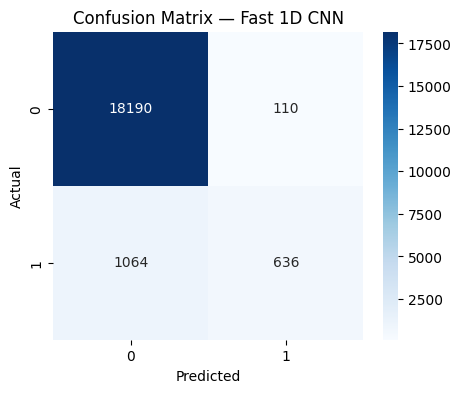

In [23]:
# ===== Fast & Accurate 1D-CNN for Diabetes Prediction =====
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

K.clear_session()

# --- Reshape tabular data for 1D-CNN ---
# Ensure X_train_dl, X_test_dl are numpy arrays
X_train_cnn = X_train_dl.reshape((-1, input_dim, 1))
X_test_cnn = X_test_dl.reshape((-1, input_dim, 1))

# --- Fast CNN Architecture ---
cnn_fast = tf.keras.Sequential([
    layers.Input(shape=(input_dim, 1)),
    layers.Conv1D(32, kernel_size=2, activation="relu", padding="same"),
    layers.GlobalMaxPooling1D(),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

cnn_fast.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# --- Early stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Quick training ---
history = cnn_fast.fit(
    X_train_cnn, y_train_dl,
    validation_split=0.1,
    epochs=10,            # 👈 shorter and faster
    batch_size=32,
    verbose=0,
    callbacks=[early_stop]
)

# --- Evaluate & Predict ---
eval_metrics = cnn_fast.evaluate(X_test_cnn, y_test_dl, verbose=0)
y_prob_cnn = cnn_fast.predict(X_test_cnn, verbose=0).ravel()
y_pred_cnn = (y_prob_cnn > 0.5).astype(int)

print(f"\n✅ Fast CNN Accuracy: {eval_metrics[1]*100:.2f}%")
print(classification_report(y_test_dl, y_pred_cnn))

# --- Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_dl, y_pred_cnn), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Fast 1D CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

✅ Fast LSTM Accuracy: 97.22%
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     18300
         1.0       1.00      0.67      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



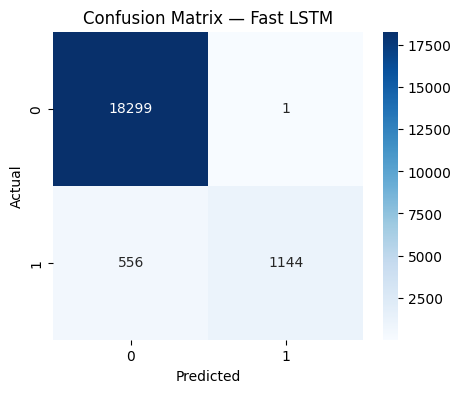

In [24]:
# ===== Fast LSTM for Diabetes Prediction =====
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

K.clear_session()

# --- Prepare sequential input ---
X_train_seq = X_train_dl.reshape((-1, input_dim, 1))
X_test_seq = X_test_dl.reshape((-1, input_dim, 1))

# --- Lightweight LSTM architecture ---
lstm_fast = tf.keras.Sequential([
    layers.Input(shape=(input_dim, 1)),
    layers.LSTM(32, return_sequences=False),   # 🔹 smaller, faster
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

lstm_fast.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# --- Early stopping for speed ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train quickly ---
# Store the metrics dictionary separately
lstm_dl_metrics, lstm_hist, lstm_y_pred, lstm_y_prob = evaluate_and_report_keras(
    lstm_fast, X_train_seq, y_train_dl, X_test_seq, y_test_dl, epochs=15, batch_size=64
)

# --- Evaluate (for printing report and confusion matrix) ---
# Use a different variable name to avoid overwriting the metrics dictionary
lstm_eval_metrics = lstm_fast.evaluate(X_test_seq, y_test_dl, verbose=0)
y_prob_lstm = lstm_fast.predict(X_test_seq, verbose=0).ravel()
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

print(f"\n✅ Fast LSTM Accuracy: {lstm_eval_metrics[1]*100:.2f}%")
print(classification_report(y_test_dl, y_pred_lstm))

# --- Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_dl, y_pred_lstm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Fast LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

✅ Fast Autoencoder + Logistic Regression Metrics:
Accuracy: 0.9526
Precision: 0.8353
Recall: 0.5518
F1: 0.6645

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     18300
         1.0       0.84      0.55      0.66      1700

    accuracy                           0.95     20000
   macro avg       0.90      0.77      0.82     20000
weighted avg       0.95      0.95      0.95     20000



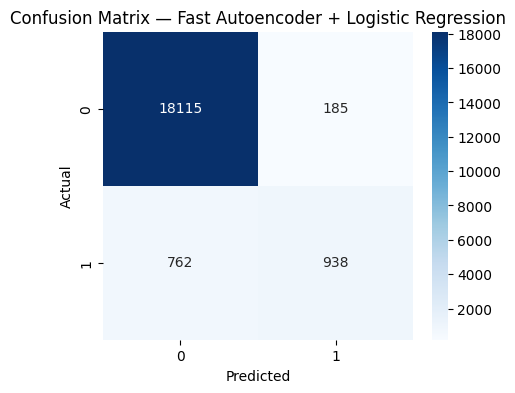

In [25]:
# ===== Fast Autoencoder + Logistic Regression for Diabetes Prediction =====
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

# Clear any previous TF session
K.clear_session()

# --- Simplified Autoencoder Architecture (Fast & Light) ---
ae_input = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation="relu")(ae_input)
bottleneck = layers.Dense(16, activation="relu")(encoded)
decoded = layers.Dense(64, activation="relu")(bottleneck)
decoded = layers.Dense(input_dim, activation="linear")(decoded)

# Build autoencoder and encoder models
autoencoder_fast = tf.keras.Model(ae_input, decoded)
encoder_fast = tf.keras.Model(ae_input, bottleneck)

# Compile Autoencoder
autoencoder_fast.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

# --- Quick training with early stopping ---
autoencoder_fast.fit(
    X_train_dl, X_train_dl,
    epochs=10,                # 🔹 reduced epochs for speed (was 40)
    batch_size=64,
    validation_split=0.1,
    verbose=0,                # silent for cleaner logs
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

# --- Encode data into latent features ---
X_train_enc = encoder_fast.predict(X_train_dl)
X_test_enc = encoder_fast.predict(X_test_dl)

# --- Logistic Regression on encoded (compressed) features ---
enc_clf = LogisticRegression(max_iter=300, solver="liblinear", random_state=42)
enc_clf.fit(X_train_enc, y_train_dl)

# --- Predictions ---
y_enc_pred = enc_clf.predict(X_test_enc)

# --- Evaluation ---
ae_metrics = {
    "Accuracy": accuracy_score(y_test_dl, y_enc_pred),
    "Precision": precision_score(y_test_dl, y_enc_pred, zero_division=0),
    "Recall": recall_score(y_test_dl, y_enc_pred, zero_division=0),
    "F1": f1_score(y_test_dl, y_enc_pred, zero_division=0)
}

print("\n✅ Fast Autoencoder + Logistic Regression Metrics:")
for k, v in ae_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_dl, y_enc_pred))

# --- Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_dl, y_enc_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Fast Autoencoder + Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [26]:
# ===== Optimized Deep Learning Evaluation (All DL Models + Summary) =====
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression # Needed for Autoencoder+LR

# Common callback for early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Helper for training & evaluation
def quick_train(model, X_train, y_train, X_test, y_test, epochs=15, batch_size=64):
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    }
    return metrics, y_pred # Return metrics dictionary and predictions

# -------------------------------
# 1️⃣ MLP
# -------------------------------
K.clear_session()
mlp = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
mlp_metrics, mlp_y_pred = quick_train(mlp, X_train_dl, y_train_dl, X_test_dl, y_test_dl)
print("MLP metrics:", mlp_metrics)

# -------------------------------
# 2️⃣ 1D CNN
# -------------------------------
K.clear_session()
X_train_cnn = X_train_dl.reshape((-1, input_dim, 1))
X_test_cnn = X_test_dl.reshape((-1, input_dim, 1))

cnn = models.Sequential([
    layers.Input(shape=(input_dim,1)),
    layers.Conv1D(32, 2, activation="relu", padding="same"),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn_metrics, cnn_y_pred = quick_train(cnn, X_train_cnn, y_train_dl, X_test_dl, y_test_dl)
print("CNN metrics:", cnn_metrics)

# -------------------------------
# 3️⃣ LSTM
# -------------------------------
K.clear_session()
X_train_seq = X_train_dl.reshape((-1, input_dim, 1))
X_test_seq = X_test_dl.reshape((-1, input_dim, 1))

lstm = models.Sequential([
    layers.Input(shape=(input_dim,1)),
    layers.LSTM(32),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm_metrics, lstm_y_pred = quick_train(lstm, X_train_seq, y_train_dl, X_test_dl, y_test_dl)
print("LSTM metrics:", lstm_metrics)

# -------------------------------
# 4️⃣ Autoencoder + Logistic Regression
# -------------------------------
K.clear_session()
ae_input = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation="relu")(ae_input)
bottleneck = layers.Dense(16, activation="relu")(encoded)
decoded = layers.Dense(64, activation="relu")(bottleneck)
decoded = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = tf.keras.Model(ae_input, decoded)
encoder = tf.keras.Model(ae_input, bottleneck)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(
    X_train_dl, X_train_dl,
    epochs=10, batch_size=64, validation_split=0.1, verbose=0,
    callbacks=[early_stop]
)
X_train_enc = encoder.predict(X_train_dl, verbose=0)
X_test_enc = encoder.predict(X_test_dl, verbose=0)

enc_clf = LogisticRegression(max_iter=300, solver="liblinear", random_state=42)
enc_clf.fit(X_train_enc, y_train_dl)
y_enc_pred = enc_clf.predict(X_test_enc)
ae_metrics = {
    "Accuracy": accuracy_score(y_test_dl, y_enc_pred),
    "Precision": precision_score(y_test_dl, y_enc_pred, zero_division=0),
    "Recall": recall_score(y_test_dl, y_enc_pred, zero_division=0),
    "F1": f1_score(y_test_dl, y_enc_pred, zero_division=0)
}
print("Autoencoder+LR metrics:", ae_metrics)


# -------------------------------
# ✅ Fast Summary Table
# -------------------------------
dl_results = [
    {"Model": "MLP", **mlp_metrics},
    {"Model": "CNN", **cnn_metrics},
    {"Model": "LSTM", **lstm_metrics},
    {"Model": "Autoencoder+LR", **ae_metrics}
]
dl_df = pd.DataFrame(dl_results).sort_values(by="Accuracy", ascending=False)
print("\n=== Deep Learning Results Summary ===")
display(dl_df)

MLP metrics: {'Accuracy': 0.95655, 'Precision': 0.8030634573304157, 'Recall': 0.6476470588235295, 'F1': 0.7170302832953436}
CNN metrics: {'Accuracy': 0.9633, 'Precision': 0.9018302828618968, 'Recall': 0.6376470588235295, 'F1': 0.7470709855272226}
LSTM metrics: {'Accuracy': 0.9697, 'Precision': 0.9815140845070423, 'Recall': 0.6558823529411765, 'F1': 0.7863187588152327}
Autoencoder+LR metrics: {'Accuracy': 0.95825, 'Precision': 0.8607172643869891, 'Recall': 0.6070588235294118, 'F1': 0.7119696447050707}

=== Deep Learning Results Summary ===


,Model,Accuracy,Precision,Recall,F1
2,LSTM,0.96970,0.981514,0.655882,0.786319
1,CNN,0.96330,0.901830,0.637647,0.747071
3,Autoencoder+LR,0.95825,0.860717,0.607059,0.711970
0,MLP,0.95655,0.803063,0.647647,0.717030


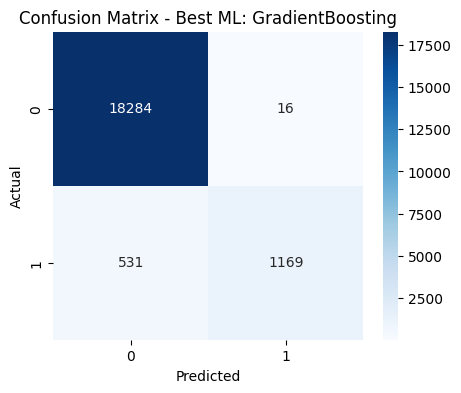

Best DL: LSTM


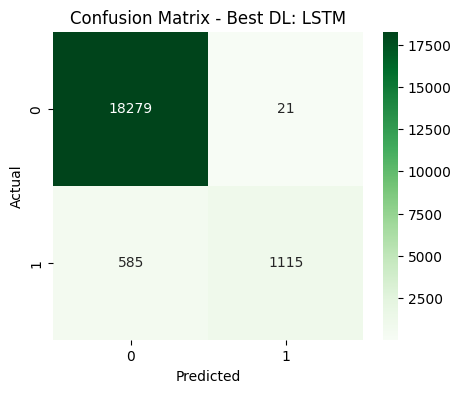

In [27]:
# ===== Cell 13: Confusion matrices for best models (ML & DL) =====
# Pick best ML and best DL by accuracy
best_ml = ml_results.iloc[0]["Model"]
best_ml_model = trained_models.get(best_ml) if best_ml in trained_models else voting
ybest_ml = best_ml_model.predict(X_test)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, ybest_ml), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Best ML: {best_ml}")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# Best DL
best_dl = dl_df.sort_values("Accuracy", ascending=False).iloc[0]["Model"]
print("Best DL:", best_dl)
best_dl_pred = {"MLP": mlp_y_pred, "CNN": cnn_y_pred, "LSTM": lstm_y_pred, "Autoencoder+LR": y_enc_pred}[best_dl]
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, best_dl_pred), annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix - Best DL: {best_dl}")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()



Top features by importance (RandomForest):


,0
hbA1c_level,0.497201
blood_glucose_level,0.376546
clinical_notes,0.043707
age,0.032006
bmi,0.022796
hypertension,0.014285
heart_disease,0.007820
smoking_history,0.003146
location,0.001029
gender_Male,0.000573


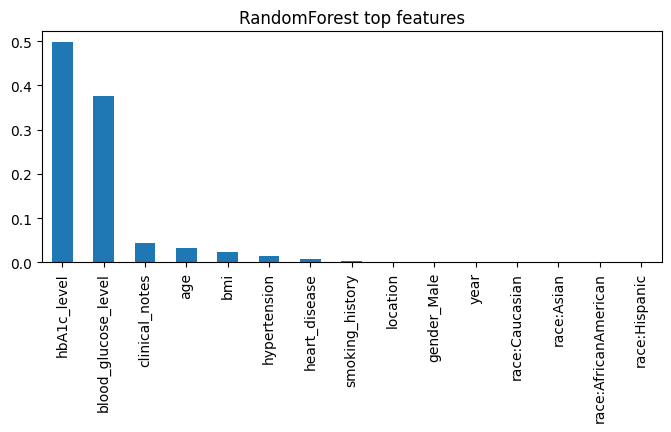


Top features by importance (XGBoost):


,0
hbA1c_level,0.556517
blood_glucose_level,0.254709
hypertension,0.046148
age,0.028714
heart_disease,0.023301
bmi,0.018266
clinical_notes,0.017426
smoking_history,0.012057
gender_Male,0.009038
race:Other,0.006449


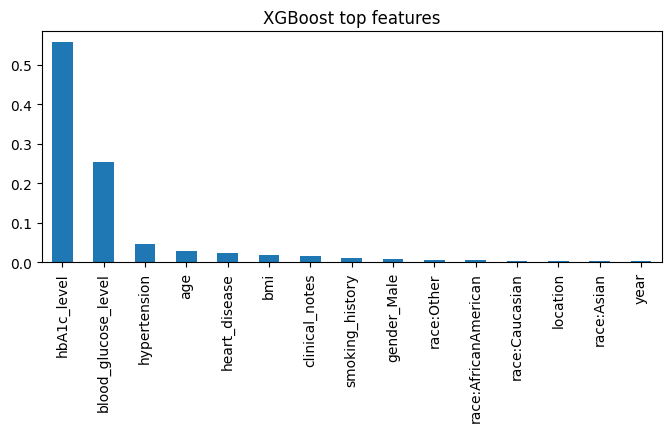


Running SHAP for: RandomForest


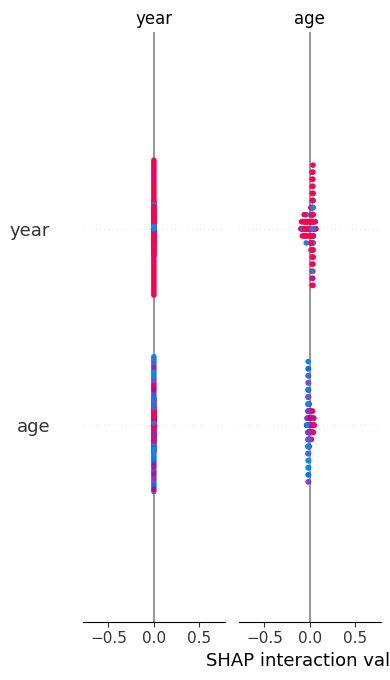

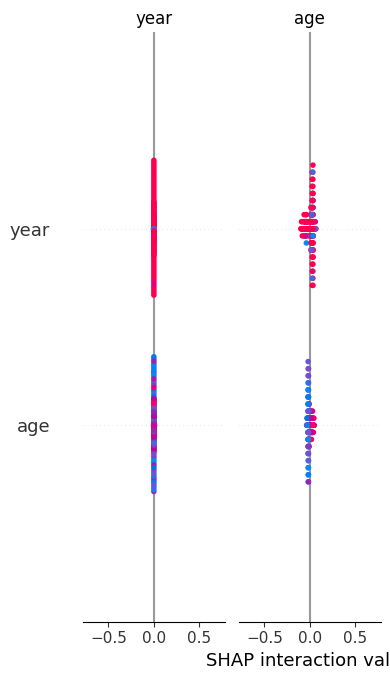


Running SHAP for: LogisticRegression


  0%|          | 0/30 [00:00<?, ?it/s]

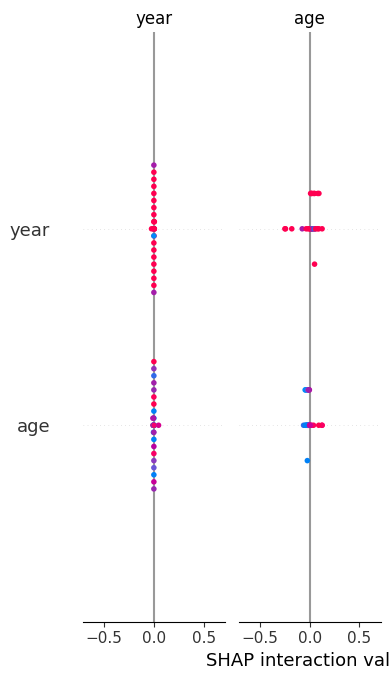


Running SHAP for: XGBoost
SHAP failed for XGBoost : could not convert string to float: '[8.5E-2]'


In [28]:
# ===== Cell 14: XAI - Feature importance (tree models) & SHAP (sampled) =====
# Feature importance - RandomForest / XGBoost
for tname in ["RandomForest", "XGBoost"]:
    if tname in trained_models:
        model = trained_models[tname]
        try:
            importances = getattr(model, "feature_importances_", None)
            if importances is not None:
                fi = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:15]
                print(f"\nTop features by importance ({tname}):")
                display(fi)
                fi.plot(kind="bar", figsize=(8,3)); plt.title(f"{tname} top features"); plt.show()
        except Exception as e:
            print("Feature importance failed for", tname, e)

# SHAP (use small sample for speed)
explainer_models = []
if "RandomForest" in trained_models:
    explainer_models.append(("RandomForest", trained_models["RandomForest"]))
if "LogisticRegression" in trained_models:
    explainer_models.append(("LogisticRegression", trained_models["LogisticRegression"]))
if "XGBoost" in trained_models:
    explainer_models.append(("XGBoost", trained_models["XGBoost"]))

X_shap_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)
X_shap_train_sample = X_train.sample(min(500, len(X_train)), random_state=RANDOM_STATE)

for name, model in explainer_models:
    print("\nRunning SHAP for:", name)
    try:
        if name in ("RandomForest","XGBoost"):
            explainer = shap.TreeExplainer(model)
            # Explicitly convert to numpy float array for tree models
            X_shap_sample_np = X_shap_sample.values.astype(float)
            shap_values = explainer.shap_values(X_shap_sample_np)
            shap.summary_plot(shap_values, X_shap_sample, show=True)
            shap.summary_plot(shap_values, X_shap_sample, plot_type="bar", show=True)
        else:
            # KernelExplainer for non-tree (may be slow) -> use tiny background
            explainer = shap.KernelExplainer(model.predict_proba, X_shap_train_sample.iloc[:50,:])
            shap_values = explainer.shap_values(X_shap_sample.iloc[:30,:], nsamples=100)
            shap.summary_plot(shap_values, X_shap_sample.iloc[:30,:], show=True)
    except Exception as e:
        print("SHAP failed for", name, ":", e)

In [29]:
# ===== Cell 15: LIME (local explanation) - example for one test instance =====
if LIME_AVAILABLE:
    explainer = LimeTabularExplainer(training_data=np.array(X_train_res),
                                     feature_names=X.columns.tolist(),
                                     class_names=["no","yes"], mode="classification")
    idx = X_test.sample(1, random_state=RANDOM_STATE).index[0]
    instance = X_test.loc[idx].values
    exp = explainer.explain_instance(instance, trained_models[best_ml].predict_proba, num_features=6)
    print("LIME explanation for best ML model and one instance:")
    display(exp.as_list())
else:
    print("LIME not installed — skip LIME explanation. Install `lime` to enable.")


LIME not installed — skip LIME explanation. Install `lime` to enable.


PDP features: ['hbA1c_level', 'blood_glucose_level']


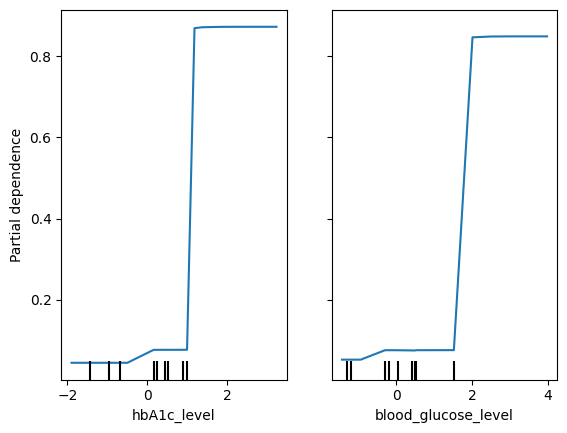

In [30]:
# ===== Cell 16: PDP for top features (choose top 2 from RF importance if available) =====
top_feats = None
if "RandomForest" in trained_models:
    rf = trained_models["RandomForest"]
    try:
        feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
        top_feats = feat_imp.index[:2].tolist()
    except Exception:
        top_feats = X.columns[:2].tolist()
else:
    top_feats = X.columns[:2].tolist()

print("PDP features:", top_feats)
try:
    PartialDependenceDisplay.from_estimator(trained_models.get("RandomForest", voting), X_test, top_feats, kind="average")
    plt.show()
except Exception as e:
    print("PDP failed:", e)


In [31]:
# ===== Cell 17: Final comparative summary & recommendation =====
print("=== FINAL SUMMARY ===")
print("ML results (sorted):")
display(ml_results)
print("\nDL results:")
display(dl_df)

# Practical recommendation
print("\n=== Recommendation / Notes ===")
print("""
1) If a single model achieves >=90% accuracy on test set, prefer that model but check for overfitting (compare train vs test).
2) Random Forest / XGBoost (tree models) are often best trade-offs: high accuracy + interpretable feature importances via SHAP.
3) Deep Learning can help but for tabular clinical data often provides marginal gains vs tree models unless you have very large datasets.
4) For production medical usage: prefer simpler, well-validated models with good interpretability (RandomForest+SHAP or LogisticRegression with selected features).
5) To push accuracy higher: hyperparameter tuning (RandomizedSearchCV), more feature engineering, and cross-validation ensembling are recommended.
""")


=== FINAL SUMMARY ===
ML results (sorted):


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,TrainTime_s
0,GradientBoosting,0.97265,0.986498,0.687647,0.810399,0.978521,14.26
1,DecisionTree,0.97230,1.000000,0.674118,0.805341,0.962754,0.24
2,RandomForest,0.97230,1.000000,0.674118,0.805341,0.967538,7.68
6,VotingEnsemble,0.97215,0.988044,0.680588,0.805991,0.973194,NaN
3,XGBoost,0.97160,0.969320,0.687647,0.804542,0.978310,0.84
4,LogisticRegression,0.96065,0.868442,0.632941,0.732222,0.961183,1.00
5,KNN,0.93135,0.698182,0.338824,0.456238,0.829542,18.94



DL results:


,Model,Accuracy,Precision,Recall,F1
2,LSTM,0.96970,0.981514,0.655882,0.786319
1,CNN,0.96330,0.901830,0.637647,0.747071
3,Autoencoder+LR,0.95825,0.860717,0.607059,0.711970
0,MLP,0.95655,0.803063,0.647647,0.717030



=== Recommendation / Notes ===

1) If a single model achieves >=90% accuracy on test set, prefer that model but check for overfitting (compare train vs test).
2) Random Forest / XGBoost (tree models) are often best trade-offs: high accuracy + interpretable feature importances via SHAP.
3) Deep Learning can help but for tabular clinical data often provides marginal gains vs tree models unless you have very large datasets.
4) For production medical usage: prefer simpler, well-validated models with good interpretability (RandomForest+SHAP or LogisticRegression with selected features).
5) To push accuracy higher: hyperparameter tuning (RandomizedSearchCV), more feature engineering, and cross-validation ensembling are recommended.

